In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from osgeo import gdal
from affine import Affine
import pandas as pd
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import seaborn as sns

import sys
sys.path.append('/Users/allen/Documents/Python/PlotGallary/')
from matplotlibconfig import basic

basic()

# plt.style.use('seaborn-white')

In [2]:
def array2raster(newRasterfn, array, lon_diff, lons, lat_diff, lats):

    pixelWidth= lon_diff
    pixelHeight= lat_diff
    cols = array.shape[1]
    rows = array.shape[0]
    originX = lons[0]
    originY = lats[0]

    driver = gdal.GetDriverByName('GTiff')
    outdata = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outdata.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    print(outdata)
    outdata.SetProjection("EPSG:4326")
    print(outdata)
    outdata.GetRasterBand(1).WriteArray(array)

In [3]:
def visual(src, scale='linear', **kwargs):
    def normalize(src, scale='linear'):
        if scale=='linear':
            return src
        elif scale=='log':
            return np.log(src)
        elif scale=='max_norm':
            return (src-np.nanmin(src))/(np.nanmax(src)-np.nanmin(src))
        elif scale=='std_norm':
            return (src-np.nanmean(src))/np.std(src)
    global lons, lats, lon_diff, lat_diff
    xres = lon_diff
    yres = lat_diff
    xmin = lats[0] + xres * 0.5
    xmax = lats[-1] - xres * 0.5
    ymin = lons[0] + yres * 0.5
    ymax = lons[-1] - yres * 0.5
    x,y = np.meshgrid(lons, lats)
    
#     fig= plt.figure(figsize=(20,8))
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-90, 91, 30), labels=[True,False,False,True], dashes=[10,10], linewidth=.5, fontsize=15)
    m.drawmeridians(np.arange(-180, 180, 45), labels=[True,False,False,True], dashes=[10,10], linewidth=.5, fontsize=15)
#     cmap= plt.get_cmap('rainbow') if cmap is None else plt.get_cmap(cmap)
    x,y = m(x,y)
    src= normalize(src, scale)
    map = m.pcolormesh(x,y,src, **kwargs)
    label= kwargs.get('label', '')
    cb = m.colorbar(location="right",size="2%", pad='10%')    
    cb.set_label(label)

    return map
#     basename = os.path.basename(FILE_NAME)
#     plt.title('{0}\n{1}'.format(basename, name+' (nchan1=0)'))
#     fig = plt.gcf()
#     pngfile = "{0}.py.png".format(basename)
#     fig.savefig(pngfile)

def marginal(src, save=False, dst=None, colorbar_label=None, cmap_range=None, cmap=None, mark_max=False,scale='linear'):
    global lon_diff, lat_diff
    widths= [6,1,0.3]
    heights= [1,4,0.3]
    fig= plt.figure(figsize=(12,7))
    fig.subplots_adjust(hspace=0)
    spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                              height_ratios=heights)
    # fig.adjust_subplot(wspace=0.1)
    ax1= fig.add_subplot(spec[0,0])
    ax1.plot(lons, np.nansum(src,axis=0), color='gray')
    ax1.set_xlim([-180,180])
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    
    max_x, max_y= np.where(src==np.nanmax(src))
#     print(max_x, max_y, src.max())
    

    
    ax2= fig.add_subplot(spec[1,0], sharex=ax1, frame_on=False)
    map= visual(src, cmap= cmap, vmin=cmap_range[0], vmax= cmap_range[1])
    if mark_max is not None:
        
        # Create a Rectangle patch
#         print(max_x, max_y)
#         for x,y in zip(max_x[0], max_y[0]):
        rect = patches.Rectangle((max_x[0]/3600., max_y[0]/1800.), 16, 10,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax2.add_patch(rect)
    
    max_lon= (max_y[0], max_y[0]+16/lon_diff)
    max_lat= (max_x[0], max_x[0]+10/lat_diff)
    
    ax_spec= fig.add_subplot(spec[0,1])
    if cmap_range:
        ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('rainbow'), vmin= cmap_range[0], vmax= cmap_range[1])
    else:
        ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('rainbow'))
    ax_spec.set_xticklabels([])
    ax_spec.set_xticks([])
    ax_spec.set_yticklabels([])
    ax_spec.set_yticks([])

    ax3= fig.add_subplot(spec[1,1])
    ax3.plot(np.nansum(src,axis=1), lats, color='gray')
    ax3.set_ylim([-90,90])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    cbar= fig.add_axes((0.2,0.03,.5,.02))
    cb = plt.colorbar( orientation='vertical', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
    if colorbar_label is not None:
        cb.set_label(colorbar_label)
    if save:
        fig.savefig(dst, dpi=144)
    fig.tight_layout(h_pad=0)
        
    return fig

def marginal_mean(src, save=False, dst=None, colorbar_label=None, cmap_range=None, cmap=None, mark_max=False, scale='linear'):
    global lon_diff, lat_diff
    widths= [6,1,0.3]
    heights= [1,4,0.3]
    fig= plt.figure(figsize=(12,7))
    fig.subplots_adjust(hspace=0)
    spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                              height_ratios=heights)
    # fig.adjust_subplot(wspace=0.1)
    ax1= fig.add_subplot(spec[0,0])
    ax1.plot(lons, np.nanmean(src,axis=0), color='gray', label='mean along latitude')
    ax1.set_xlim([-180,180])
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.hlines(1.0, lons[0], lons[-1], color='red')
    ax1.set_ylim([0,2])
    ax1.legend()
    
    max_x, max_y= np.where(src==np.nanmax(abs(src)))
#     print(max_x, max_y, src.max())
    ax2= fig.add_subplot(spec[1,0], sharex=ax1, frame_on=False)
    map= visual(src, cmap, cmap_range,scale=scale)
    
    if mark_max:
        # Create a Rectangle patch
#         print(max_x, max_y)
#         for x,y in zip(max_x[0], max_y[0]):
        rect = patches.Rectangle((max_x[0]/3600., max_y[0]/1800.), 16, 10,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax2.add_patch(rect)
    
    max_lon= (max_y[0], max_y[0]+16/lon_diff)
    max_lat= (max_x[0], max_x[0]+10/lat_diff)
    
    if mark_max:
        ax_spec= fig.add_subplot(spec[0,1])
        if cmap_range:
            ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('bwr'), vmin= cmap_range[0], vmax= cmap_range[1])
        else:
            ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('bwr'))
        ax_spec.set_xticklabels([])
        ax_spec.set_xticks([])
        ax_spec.set_yticklabels([])
        ax_spec.set_yticks([])

    ax3= fig.add_subplot(spec[1,1])
    ax3.plot(np.nanmean(src,axis=1), lats, color='gray', label='mean along longitude')
    ax3.vlines(1,lats[0], lats[-1], color='red')
    ax3.set_ylim([-90,90])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax3.set_xlim([0,2])
#     ax3.legend()
    cbar= fig.add_axes((0.2,0.03,.5,.02))
    cb = plt.colorbar(orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
    if colorbar_label is not None:
        cb.set_label(colorbar_label)
    if save:
        fig.savefig(dst, dpi=144)
    fig.tight_layout(h_pad=0)
        
    return fig

def marginal_median(src, save=False, dst=None, colorbar_label=None, cmap_range=None, cmap=None, mark_max=False, scale='linear'):
    global lon_diff, lat_diff
    widths= [6,1,0.3]
    heights= [1,4,0.3]
    fig= plt.figure(figsize=(12,7))
    fig.subplots_adjust(hspace=0)
    spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                              height_ratios=heights)
    # fig.adjust_subplot(wspace=0.1)
    ax1= fig.add_subplot(spec[0,0])
    ax1.plot(lons, np.nanmedian(src,axis=0), color='gray', label='median along latitude')
    ax1.set_xlim([-180,180])
    ax1.set_xticklabels([])
    ax1.set_xticks([])
#     ax1.hlines(1.0, lons[0], lons[-1], color='red')
    ax1.set_ylim([0,2])
    ax1.legend()
    
    max_x, max_y= np.where(src==np.nanmax(abs(src)))
#     print(max_x, max_y, src.max())
    ax2= fig.add_subplot(spec[1,0], sharex=ax1, frame_on=False)
    map= visual(src, cmap, cmap_range,scale=scale)
    
    if mark_max:
        # Create a Rectangle patch
#         print(max_x, max_y)
#         for x,y in zip(max_x[0], max_y[0]):
        rect = patches.Rectangle((max_x[0]/3600., max_y[0]/1800.), 16, 10,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax2.add_patch(rect)
    
    max_lon= (max_y[0], max_y[0]+16/lon_diff)
    max_lat= (max_x[0], max_x[0]+10/lat_diff)
    
    if mark_max:
        ax_spec= fig.add_subplot(spec[0,1])
        if cmap_range:
            ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('bwr'), vmin= cmap_range[0], vmax= cmap_range[1])
        else:
            ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('bwr'))
        ax_spec.set_xticklabels([])
        ax_spec.set_xticks([])
        ax_spec.set_yticklabels([])
        ax_spec.set_yticks([])

    ax3= fig.add_subplot(spec[1,1])
    ax3.plot(np.nanmedian(src,axis=1), lats, color='gray', label='median along longitude')
#     ax3.vlines(1,lats[0], lats[-1], color='red')
    ax3.set_ylim([-90,90])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax3.set_xlim([0,2])
#     ax3.legend()
    cbar= fig.add_axes((0.2,0.03,.5,.02))
    cb = plt.colorbar(orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
    if colorbar_label is not None:
        cb.set_label(colorbar_label)
    if save:
        fig.savefig(dst, dpi=144)
    fig.tight_layout(h_pad=0)
        
    return fig

def marginal_surface(src, alt, save=False, dst=None, colorbar_label=None, cmap_range=None, cmap=None, mark_max=False):
    global lon_diff, lat_diff
    widths= [6,1,0.3]
    heights= [1,4,0.3]
    fig= plt.figure(figsize=(12,7))
    fig.subplots_adjust(hspace=0)
    spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                              height_ratios=heights)
    # fig.adjust_subplot(wspace=0.1)
    
    # accumulate number of samples
    
    ax1= fig.add_subplot(spec[0,0])
#     ax1.bar(lons, np.nansum(alt,axis=0)/np.nansum(alt), color='gray', alpha=0.4, label='num of samples')
    ax1.plot(lons, np.nanmedian(src,axis=0), color='red', label='rmse along latitude')
    ax1.set_xlim([-180,180])
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.legend()
    
    max_x, max_y= np.where(src==np.nanmax(src))
#     print(max_x, max_y, src.max())
    

    
    ax2= fig.add_subplot(spec[1,0], sharex=ax1, frame_on=False)
    map= visual(src, cmap, vmin= cmap_range[0], vmax=cmap_range[1])
#     if mark_max:
        
#         # Create a Rectangle patch
# #         print(max_x, max_y)
# #         for x,y in zip(max_x[0], max_y[0]):
#         rect = patches.Rectangle((max_x[0]/3600., max_y[0]/1800.), 16, 10,linewidth=2,edgecolor='r',facecolor='none')
#         # Add the patch to the Axes
#         ax2.add_patch(rect)
    
    max_lon= (max_y[0], max_y[0]+16/lon_diff)
    max_lat= (max_x[0], max_x[0]+10/lat_diff)
    
    ax_spec= fig.add_subplot(spec[0,1])
    if cmap_range:
        ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('rainbow'), vmin= cmap_range[0], vmax= cmap_range[1])
    else:
        ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('rainbow'))
    ax_spec.set_xticklabels([])
    ax_spec.set_xticks([])
    ax_spec.set_yticklabels([])
    ax_spec.set_yticks([])

    ax3= fig.add_subplot(spec[1,1])
#     ax3.plot(alt.sum(axis=1)/alt.sum(), lats, color='gray', alpha=0.4, label='num of samples')
    ax3.fill_between(alt.sum(axis=1)/alt.sum(), lats, color='gray')
    ax3.plot(np.nanmean(src,axis=1), lats, color='red', label='rmse along latitude')
    ax3.set_ylim([-90,90])
    ax3.set_xlim([0,5])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
#     ax3.legend()
    cbar= fig.add_axes((0.2,0.03,.5,.02))
    cb = plt.colorbar( orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
    if colorbar_label is not None:
        cb.set_label(colorbar_label)
    if save:
        fig.savefig(dst, dpi=144)
    fig.tight_layout(h_pad=0)
        
    return fig

### Read data

In [41]:
np.nanmedian(np.divide(rmse, daily_rain**.5, where=daily_rain!=0))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


0.6283165628563571

In [4]:
h5= h5py.File('test_sample.HDF5','r')
result= h5py.File('datasets/post_result.h5','r')
grided_map= h5['Grid']
# load geo information
lons= np.array(h5['Grid/lon'])
lats= np.array(h5['Grid/lat'])
data= np.array(h5['Grid/precipitationCal']).transpose()
data[data<0]= np.nan
xmin, ymin, xmax, ymax = [lons.min(), lats.min(), lons.max(), lats.max()]
xres, yres, _= data.shape
ncol, nrow= int((xmax-xmin)//xres), int((ymax-ymin)//yres)
lon_diff= lons[1]-lons[0]
lat_diff= lats[1]-lats[0]

#load each item
early_sum= result['early sum'][:]
final_sum= result['final sum'][:]
early_sum[early_sum<1]=np.nan
final_sum[final_sum<1]=np.nan
bias= np.divide(early_sum-final_sum, final_sum, out= np.full(early_sum.shape,np.nan) )
mae= result['mae'][:]*6969*48
rmse= result['rmse'][:]**2*6969*48
rainySamples= result['prob'][:][:3,:,:].sum(axis=0)
mae= np.divide(mae, rainySamples, out= np.full(mae.shape, np.nan))*2
rmse= np.divide(rmse, rainySamples, out= np.full(rmse.shape, np.nan))
rmse= rmse**.5*2
daily_rain= np.divide(final_sum, 6969, out= np.full(final_sum.shape, np.nan))

_prob= result['prob'][:]
a,b,c,d= _prob[0,:,:],_prob[1,:,:],_prob[2,:,:],_prob[3,:,:]
FAR= np.divide(b, a+b, out=np.full(a.shape, np.nan))
POD= np.divide(a, a+c, where=(a+b)>0, out=np.full(a.shape, np.nan))
CSI= np.divide(a, a+b+c, where=(a+b+c)>0, out=np.full(a.shape, np.nan))

rainy_E= a+c
rainy_F= a+b
bias_rainy= np.divide(rainy_E-rainy_F, rainy_F, where= rainy_F!=0, out= np.full(early_sum.shape,np.nan))

#load land-cover
glob_cls= gdal.Open('geotiffs/RenderData.tiff')
glob_cls= glob_cls.ReadAsArray()
glob_cls= np.flip(glob_cls, axis=0)

sea= np.where(glob_cls==0)
land= np.where(glob_cls!=0)

# rmse_land= rmse.copy()/ (final_sum/np.nansum(result['prob'][[0,1],:,:],axis=0))
rmse_land= rmse.copy()
rmse_land[sea]=np.nan
# rmse_sea= rmse.copy()/(final_sum/np.nansum(result['prob'][[0,1],:,:],axis=0))
rmse_sea= rmse.copy()
rmse_sea[land]=np.nan
bias_land= bias.copy()
bias_sea= bias.copy()
bias_land[sea]= np.nan
bias_sea[land]= np.nan

bias_rainy_land= bias_rainy.copy()
bias_rainy_sea= bias_rainy.copy()
bias_rainy_land[sea]= np.nan
bias_rainy_sea[land]=np.nan

# num_land= num.copy()
# num_land[sea]= 0
# num_sea= num.copy()
# num_sea[land]= 0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


In [8]:
np.nanmedian(bias_land)

0.13824535555414533

### Quantitative

#### Final sum

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


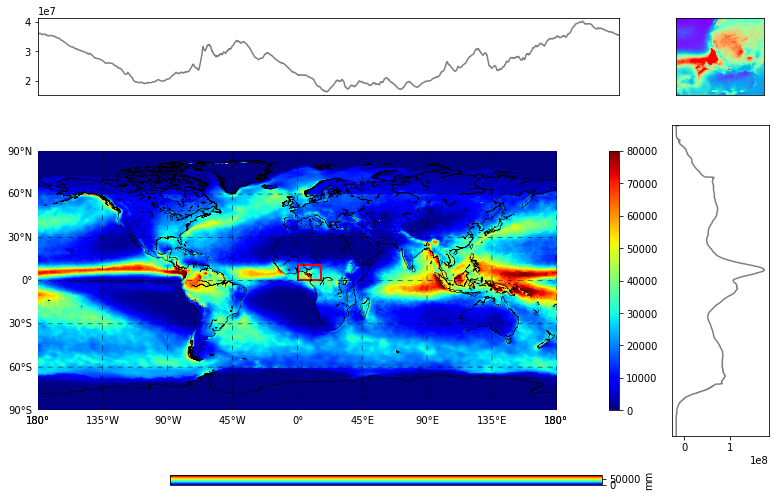

In [5]:
fig= marginal(result['final sum'][:], save=False, colorbar_label='mm', mark_max=True, cmap_range=(0,80000), cmap='jet')
# fig.savefig('total_amount.png', dpi=144)

#### Bias

$$relative bias=\frac{early-final}{final}$$

In [22]:
x,y= np.meshgrid(lons, lats)

In [23]:
x[bias>0][2579399]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


19.65

In [24]:
y[bias>0][2579399]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


22.45

In [20]:
np.argmin(abs(bias[bias>0]-np.quantile(bias[bias>0], 0.99)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


2579399

In [17]:
np.where(bias==np.quantile(bias[bias>0], 0.99))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(array([], dtype=int64), array([], dtype=int64))

In [7]:
np.nanmax(bias[bias>0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


1281595.7435082141

In [6]:
(bias>0).sum()/(~np.isnan(bias)).sum()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.718587537043241

/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


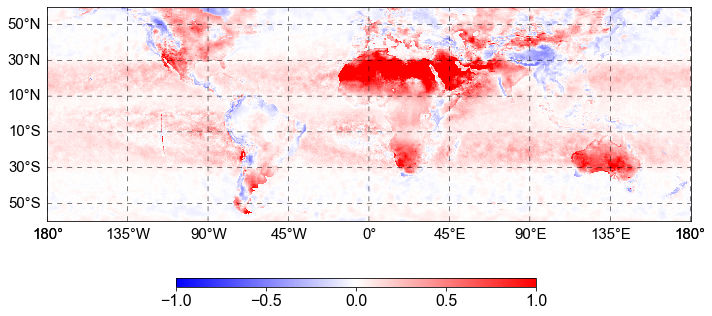

In [5]:
fig= plt.figure(figsize=(10,6))
map= visual(bias, cmap='bwr', vmin=-1, vmax=1)
cbar= fig.add_axes((0.25,0.1,.5,.02))
plt.colorbar(orientation='horizontal', cax= cbar, shrink=.7, fraction= .7)
# fig.savefig('early_final_ratio.png', dpi=144)

In [6]:
array2raster('bias.tif', bias, lon_diff, lons, lat_diff, lats)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x142c68b70> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x142c68b70> >


### Difference

#### Mean Absolute Difference

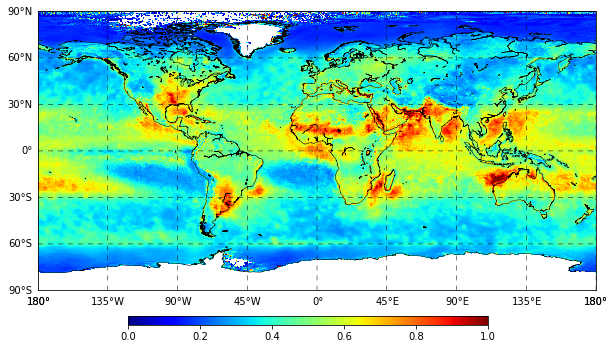

In [25]:
fig= plt.figure(figsize=(10,6))
map= visual(mae, cmap='jet', vmin=0, vmax=1)
cbar= fig.add_axes((0.25,0.1,.5,.02))
plt.colorbar(orientation='horizontal', cax= cbar, shrink=.7, fraction= .7)
fig.savefig('mad.png', dpi=144)

#### Root Mean Squared Difference

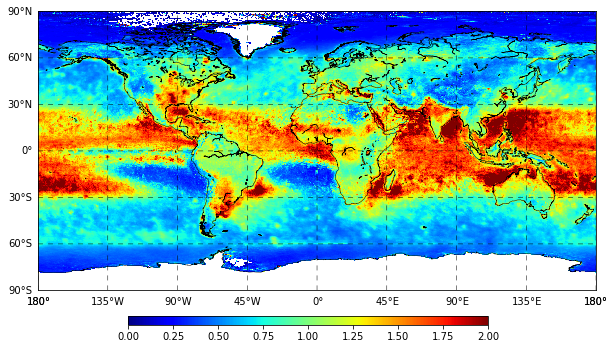

In [28]:
fig= plt.figure(figsize=(10,6))
map= visual(rmse, cmap='jet', vmin=0, vmax=2)
cbar= fig.add_axes((0.25,0.1,.5,.02))
plt.colorbar(orientation='horizontal', cax= cbar, shrink=.7, fraction= .7)
fig.savefig('rmsd.png', dpi=144)

### categorical difference

__FAR__

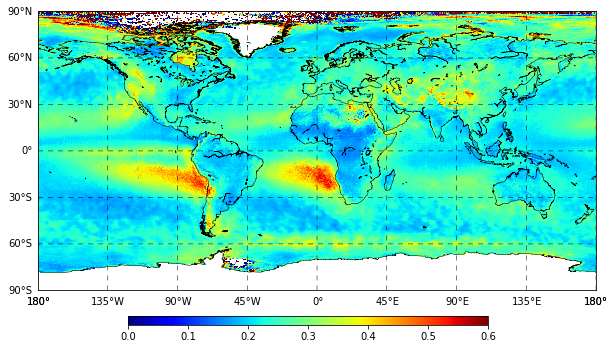

In [19]:
fig= plt.figure(figsize=(10,6))
map= visual(FAR, vmin=0, vmax=0.6, cmap='jet')
cbar= fig.add_axes((0.25,0.1,.5,.02))
plt.colorbar(orientation='horizontal', cax= cbar, shrink=.7, fraction= .7)
fig.savefig('FAR.png', dpi=144)

### Sea-Land seperation

In [33]:
np.nanmedian(norm_sea)

0.36699590989771563

In [23]:
norm_land= np.divide(rmse_land-0.4547, daily_rain**.5, where= daily_rain>0, out=np.full(daily_rain.shape, np.nan))
norm_sea= np.divide(rmse_sea-0.4547, daily_rain**.5, where= daily_rain>0, out=np.full(daily_rain.shape, np.nan))
# fig= plt.figure(figsize=(12, 6))
# map= visual(norm_land, vmin=0, vmax=2, cmap='jet')
# cbar= fig.add_axes((0.25,0.03,.5,.02))
# plt.colorbar(orientation='horizontal', cax= cbar, shrink=.7, fraction= .7)
# fig.savefig('land_rmse_norm.png', dpi=144) 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [21]:
np.nanmedian(np.divide(rmse-0.4547, daily_rain**.5, where= daily_rain>0, out=np.full(daily_rain.shape, np.nan)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.9270960655593015

In [17]:
x,y= np.meshgrid(lons, lats)

In [19]:
_bias= bias[~np.isnan(bias)]
_x = x[~np.isnan(bias)]
_y = y[~np.isnan(bias)]
(_x[np.argmax(_bias)], _y[np.argmax(_bias)])

(-140.55, 60.15)

In [20]:
np.nanmax(_bias)

1264.0891609008354

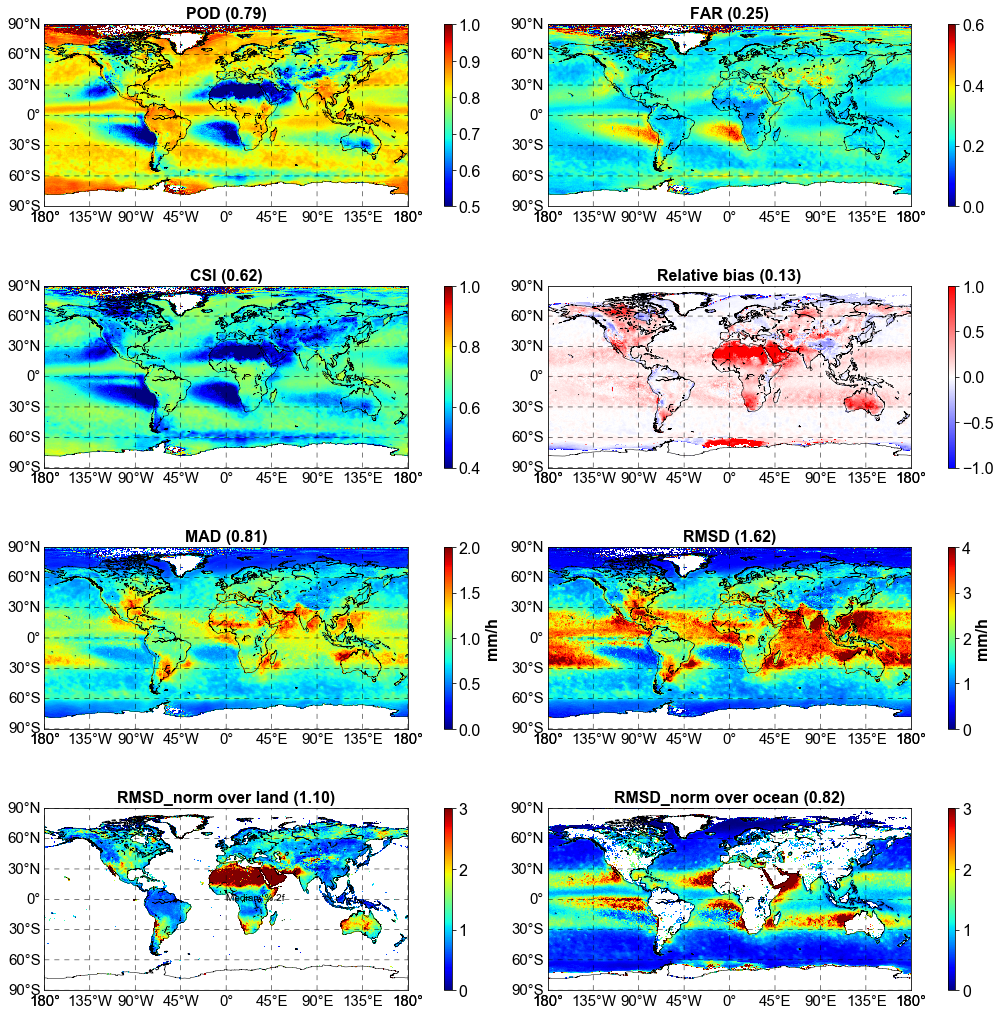

In [24]:
fig= plt.figure(figsize=(14, 16))

ax2= fig.add_subplot(421)
ax2.set_title('POD (%.2f)'%(np.nanmean(POD)), fontsize=16, weight='bold')
map= visual(POD, cmap='jet', vmin=0.5, vmax=1)

ax2= fig.add_subplot(422)
ax2.set_title('FAR (%.2f)'%(np.nanmean(FAR)), fontsize=16, weight='bold')
map= visual(FAR, cmap='jet', vmin=0, vmax=.6)

ax2= fig.add_subplot(423)
ax2.set_title('CSI (%.2f)'%(np.nanmean(CSI)), fontsize=16, weight='bold')
map= visual(CSI, cmap='jet', vmin=0.4, vmax=1)

ax2= fig.add_subplot(424)
ax2.set_title('Relative bias (%.2f)'%(np.nanmean(bias)), fontsize=16, weight='bold')
map= visual(bias, cmap='bwr', vmin=-1, vmax=1)

ax2= fig.add_subplot(425)
map= visual(mae, cmap='jet', vmin=0, vmax=2, label='mm/h')
ax2.set_title('MAD (%.2f)'%(np.nanmedian(mae)), fontsize=16, weight='bold')

ax2= fig.add_subplot(426)
map= visual(rmse, cmap='jet', vmin=0, vmax=4, label='mm/h')
ax2.set_title('RMSD (%.2f)'%(np.nanmedian(rmse)), fontsize=16, weight='bold')

ax2= fig.add_subplot(427)
map= visual(norm_land, vmin=0, vmax=3, cmap='jet')
ax2.set_title('RMSD_norm over land (%.2f)'%(np.nanmedian(norm_land)), fontsize=16, weight='bold')
ax2.text(0.2, -1, 'Median: %.2f')

ax2= fig.add_subplot(428)
map= visual(norm_sea, vmin=0, vmax=3, cmap='jet')
ax2.set_title('RMSD_norm over ocean (%.2f)'%(np.nanmedian(norm_sea)), fontsize=16, weight='bold')

fig.tight_layout();

In [25]:
fig.savefig('combo1.png', dpi=300)

# Earth surface decomposition

In [18]:
bias_coast= pd.read_csv('coast_bias.csv').to_numpy()
bias_rainy_coast= pd.read_csv('coast_bias_rainy.csv').to_numpy()

In [19]:
bias_land= bias_land.reshape(-1)
bias_land= bias_land[~np.isnan(bias_land) & (bias_land<1) & (bias_land>-1)]
bias_sea= bias_sea.reshape(-1)
bias_sea= bias_sea[~np.isnan(bias_sea)& (bias_sea<1) & (bias_sea>-1)]
bias_coast= bias_coast.reshape(-1)
bias_coast= bias_coast[~np.isnan(bias_coast)& (bias_coast<1) & (bias_coast>-1)]

bias_rainy_land= bias_rainy_land.reshape(-1)
bias_rainy_land= bias_rainy_land[~np.isnan(bias_rainy_land) & (bias_rainy_land<1) & (bias_rainy_land>-1)]
bias_rainy_sea= bias_rainy_sea.reshape(-1)
bias_rainy_sea= bias_rainy_sea[~np.isnan(bias_rainy_sea)& (bias_rainy_sea<1) & (bias_rainy_sea>-1)]
bias_rainy_coast= bias_rainy_coast.reshape(-1)
bias_rainy_coast= bias_rainy_coast[~np.isnan(bias_rainy_coast)& (bias_rainy_coast<1) & (bias_rainy_coast>-1)]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [14]:
from scipy import stats

In [41]:
counts,vals= np.histogram(bias_rainy_sea, bins=100)
vals[np.argmax(counts)]

-0.05842555331991961

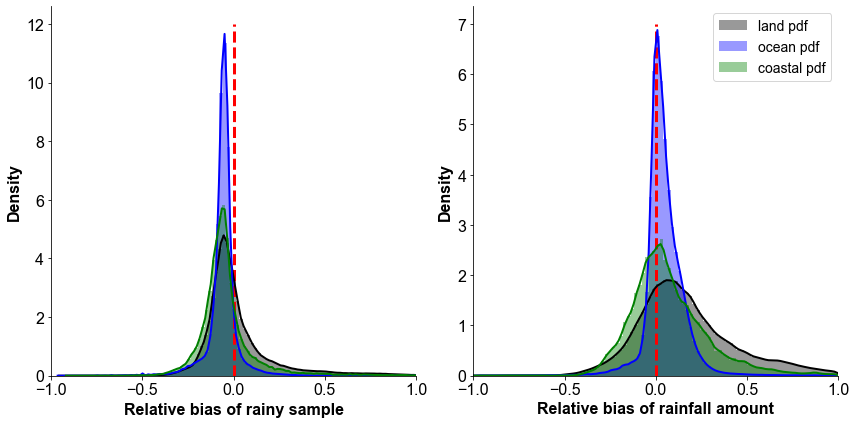

In [20]:
fig= plt.figure(figsize=(12,6))
ax_0= fig.add_subplot(122)
ax_0= sns.distplot(bias_land, color='black', label='land pdf', bins=100);
ax_0= sns.distplot(bias_sea, color= 'blue', label='ocean pdf', bins=100);
ax_0= sns.distplot(bias_coast, color='green', label='coastal pdf', bins=100);
ax_0.set_xlim([-1,1])
ax_0.set_xlabel('Relative bias of rainfall amount', fontsize=16)
ax_0.set_ylabel('Density', fontsize=16)
ax_0.spines['top'].set_visible(False)
ax_0.spines['right'].set_visible(False)
ax_0.vlines(0,0,7,'r','--', linewidth=3)
ax_0.legend()
ax= fig.add_subplot(121)
ax= sns.distplot(bias_rainy_land, color='black', label='land pdf', bins=100);
ax= sns.distplot(bias_rainy_sea, color= 'blue', label='ocean pdf', bins=100);
ax= sns.distplot(bias_rainy_coast, color='green', label='coastal pdf', bins=100);
ax.set_xlim([-1,1])
ax.set_xlabel('Relative bias of rainy sample', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.vlines(0,0,12,'r','--', linewidth=3);

In [22]:
np.nanmedian(bias_land)

0.12212124360874488

In [12]:
fig.savefig('earth_surface_bias.png', dpi=300)

In [2]:
import pandas as pd

In [4]:
list(pd.date_range('20000601', '20190630', freq='30T'))

[Timestamp('2000-06-01 00:00:00', freq='30T'),
 Timestamp('2000-06-01 00:30:00', freq='30T'),
 Timestamp('2000-06-01 01:00:00', freq='30T'),
 Timestamp('2000-06-01 01:30:00', freq='30T'),
 Timestamp('2000-06-01 02:00:00', freq='30T'),
 Timestamp('2000-06-01 02:30:00', freq='30T'),
 Timestamp('2000-06-01 03:00:00', freq='30T'),
 Timestamp('2000-06-01 03:30:00', freq='30T'),
 Timestamp('2000-06-01 04:00:00', freq='30T'),
 Timestamp('2000-06-01 04:30:00', freq='30T'),
 Timestamp('2000-06-01 05:00:00', freq='30T'),
 Timestamp('2000-06-01 05:30:00', freq='30T'),
 Timestamp('2000-06-01 06:00:00', freq='30T'),
 Timestamp('2000-06-01 06:30:00', freq='30T'),
 Timestamp('2000-06-01 07:00:00', freq='30T'),
 Timestamp('2000-06-01 07:30:00', freq='30T'),
 Timestamp('2000-06-01 08:00:00', freq='30T'),
 Timestamp('2000-06-01 08:30:00', freq='30T'),
 Timestamp('2000-06-01 09:00:00', freq='30T'),
 Timestamp('2000-06-01 09:30:00', freq='30T'),
 Timestamp('2000-06-01 10:00:00', freq='30T'),
 Timestamp('2